In [60]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [61]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

The following function for creating block-tridiagonal matrices was found here: https://stackoverflow.com/a/62904889. 

In [62]:
def block_tridiag(c, d, u, N): 
    center = block_diag(*([c]*N)) 
    shift = c.shape[1]

    upper = block_diag(*([u]*N)) 
    upper = np.hstack((np.zeros((upper.shape[0], shift)), upper[:,:-shift]))
    
    lower = block_diag(*([d]*N)) 
    lower = np.hstack((lower[:,shift:],np.zeros((upper.shape[0], shift))))
    return center+upper+lower

We define some test functions:

$exact_1(x,y) = x^3y^3$
$f_1(x,y) = 6(a+1)xy^3+18rx^2y^2+6r^2x^3y$

$exact_2(x,y) = \cos{x} \sin{y}$
$f_2(x,y) = -(a+1)\cos{x} \sin{y} - 2r \sin{x} \cos{y} -r^2 \cos{x}\sin{y}$



In [63]:
def exact1(x,y):
    return x**3*y**3

def exact2(x,y):
    return np.cos(x)*np.sin(y)

def exact3(x,y):
    return np.sin(10*x)*y

In [64]:
def f1(x,y,r=2):
    a = 1
    return 6*(a+1)*x*y**3+18*r*x**2 * y**2+6*r**2*x**3*y

def f2(x,y,r=2):
    a = 1
    return -(a+1)*np.cos(x)*np.sin(y)-2*r*np.sin(x)*np.cos(y)-(r**2)*np.cos(x)*np.sin(y)

def f3(x,y):
    return -100*np.sin(10*x)*y

In [65]:
def g(x,y,boundary = exact1):
    """ x: array of length M+1
        y: array of length ysteps+1
        returns: the contributions from the B.C. on the inner grid
    """
    a = 1
    xi = x[1:-1]
    yi = y[1:-1]
    M = len(xi)+1
    N = len(yi)+1

    B = np.zeros((N-1,M-1))
    B[:-1,0] = a*boundary(x[0],yi[0:-1]) + boundary(x[0],y[:-3]) #Bottom left corner and left column
    B[0,1:-1] = boundary(xi[0:-2],0) #Bottom row

    B[0,-1] = a*boundary(x[-1],y[1]) + (boundary(xi[-2],0)+boundary(x[-1],y[2])) #Bottom right corner
    B[1:,-1] = a*boundary(x[-1],yi[1:]) + boundary(x[-1],y[3:]) #Right column and top right corner

    B[-1,0] = boundary(xi[1],y[-1])+boundary(x[0],yi[-2]) + a*boundary(x[0],yi[-1]) #Top left corner
    B[-1,1:-1] = boundary(xi[2:],y[-1]) #Top row

    if (y[-1] > 2): #Fatten the boundary (strictly unnecessary to do this here, could change y[-1] to 2 above)
        B[-1,1:-1] = boundary(xi[2:],2) #Top row
        B[-1,0] = boundary(xi[1],2)+boundary(x[0],yi[-2]) + a*boundary(x[0],yi[-1]) #Top left corner
        B[-1,-1] = a*boundary(x[-1],yi[-1]) + boundary(x[-1],2) #Top right corner
    
    return B.flatten()

In [66]:
def poisson(f,g,boundary,M=10,r=2):
    """ f: RHS of equation
        g: boundary contribution to inner points
        boundary: B.C. (Dirichlet)
        M: # of steps in x-direction
        r: Scaling parameter to step size in y-direction
    """
    a = 1

    h = 1/M
    k = np.abs(r) * h
    ysteps = 2/k
    if (2%k != 0): #We miss the upper boundary
        ysteps = int(2//k) + 1  # Fattening the boundary by adding +1

    #Initialize grid
    x = np.linspace(0,1,M+1) 
    y = np.linspace(0,ysteps*k,ysteps+1)
    xi = x[1:-1] #Inner x-array
    yi = y[1:-1] #Inner y-array
    Xi,Yi = np.meshgrid(xi,yi) #Inner grid
    X,Y = np.meshgrid(x,y) #Entire grid, including boundaries

    U = boundary(X,Y) 
    U[1:-1,1:-1] = np.zeros((ysteps-1,M-1)) 

    #Correct the upper boundary if we miss it
    if (y[-1] > 2):
        U[-1,:] = boundary(x,2)
    
    # Matrix on diagonal:
    D = tridiag(-a, 2*(a+1), -a, M-1)
    # Matrix on lower diagonal:
    SD = tridiag(-1, 0, 0, M-1)
    # Matrix on upper diagonal:
    UD = tridiag(0, 0, -1, M-1)

    # Block matrix: (first parameter on diagonal, second on subdiagonal)
    A = block_tridiag(D, SD, UD, ysteps-1)
    
    #Create RHS
    b = -f(Xi,Yi,r = r) * h**2 
    b = b.flatten() + g(x,y,boundary = boundary)

    #Solve for inner points
    Ui = np.linalg.solve(A,b)

    #Reshape and set solution together
    U[1:-1,1:-1] = np.reshape(Ui,(ysteps-1,M-1))

    return X,Y,U



## a) 

r = 2



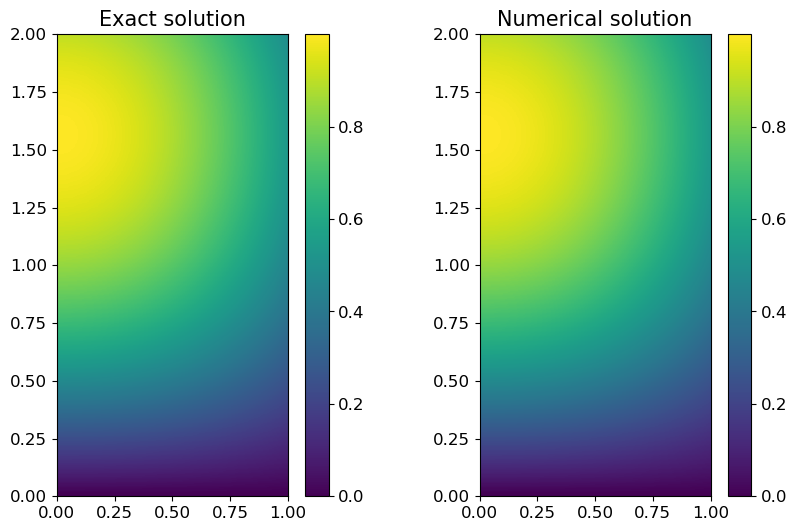

In [67]:
X,Y,U = poisson(f2,g,exact2, M = 100)

fig,axs = plt.subplots(1,2,figsize=(10,6))

axs[0].set_title("Exact solution", fontsize=15)
#We invert the grids to show the solutions on the normal Cartesian system
im = axs[0].imshow(exact2(X,Y)[::-1],extent = [0,1,0,2])
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[0])
cbar.ax.tick_params(labelsize=12)


axs[1].set_title("Numerical solution", fontsize=15)
im = axs[1].imshow(U[::-1],extent = [0,1,0,2])
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[1])
cbar.ax.tick_params(labelsize=12)


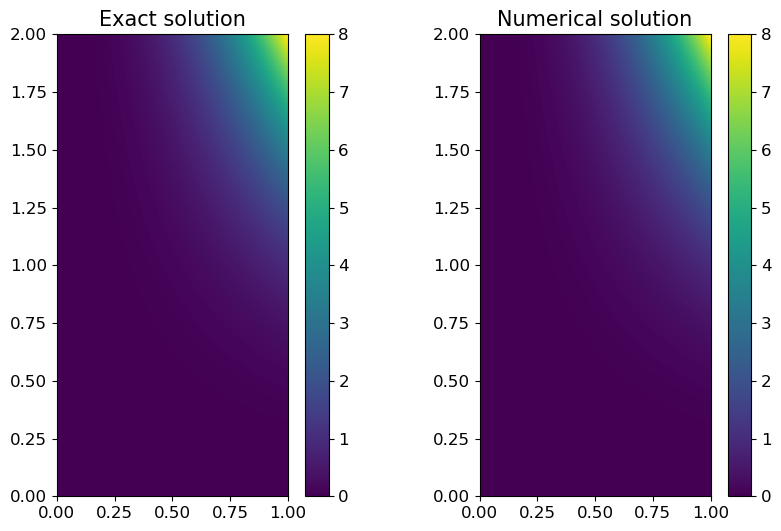

In [68]:
X,Y,U = poisson(f1,g,exact1, M = 100)

fig,axs = plt.subplots(1,2,figsize=(10,6))

axs[0].set_title("Exact solution", fontsize=15)
#We invert the grids to show the solutions on the normal Cartesian system
im = axs[0].imshow(exact1(X,Y)[::-1],extent = [0,1,0,2])
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[0])
cbar.ax.tick_params(labelsize=12)


axs[1].set_title("Numerical solution", fontsize=15)
im = axs[1].imshow(U[::-1],extent = [0,1,0,2])
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[1])
cbar.ax.tick_params(labelsize=12)


## c)

We do a convergence analysis by successively refining the grid. 

In [69]:
#This function is copied from "heat_forweuler.ipynb" and modified to our purposes
def converge_h(f,g,u_exact,r = 2, solver = poisson):
    K = 5
    Hconv = np.zeros(K)
    Econv = np.zeros(K)
    M = 5
    for k in range(K):
        X,Y,U = solver(f, g,u_exact,M=M,r=r)
        Exact = u_exact(X,Y) - U
        Hconv[k] = (X[0,1]-X[0,0])
        Econv[k] = np.max(np.abs(Exact))
        M = M*2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

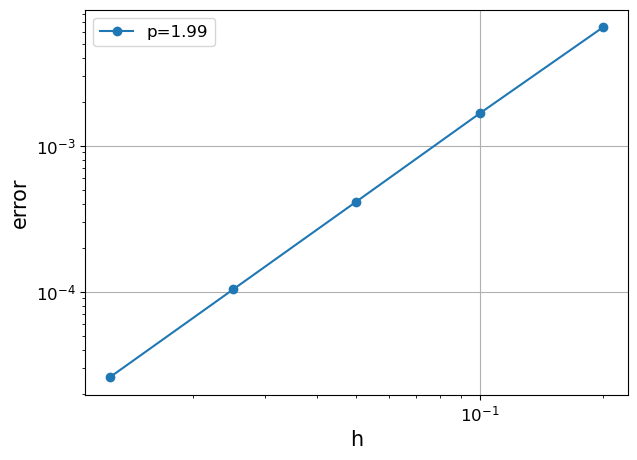

In [70]:
h,e,o = converge_h(f2,g,exact2)

plt.figure(figsize=(7,5))
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12); 

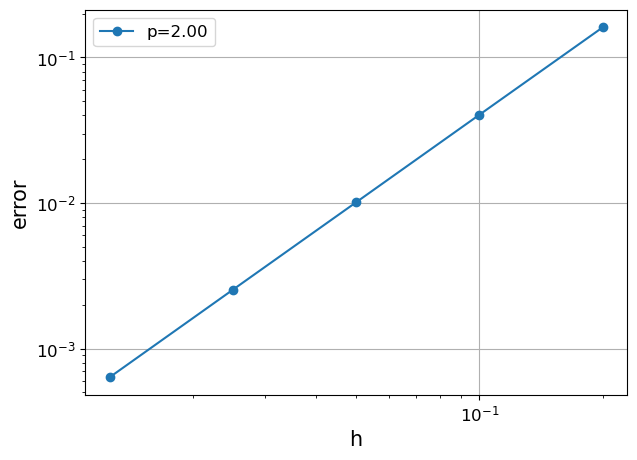

In [71]:
h,e,o = converge_h(f1,g,exact1)

plt.figure(figsize=(7,5))
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12); 

## d)

We apply the scheme again, but this time with a different $r \notin \mathbb{Q}$. This means that we miss the upper boundary and have to adjust our grid by extending the boundary upwards. 

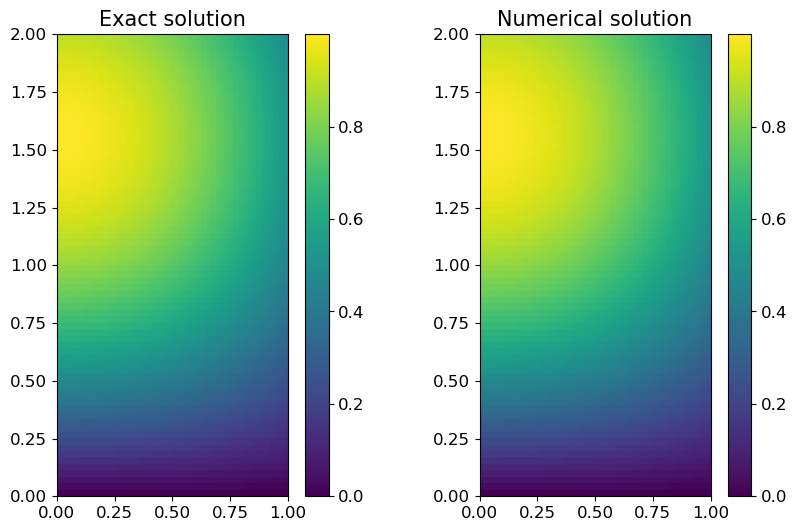

In [72]:
#r = sqrt(2) (irrational)
X,Y,U = poisson(f2,g,exact2, M = 50,r = np.sqrt(2))

fig,axs = plt.subplots(1,2,figsize=(10,6))

axs[0].set_title("Exact solution", fontsize=15)
#We invert the grids to show the solutions on the normal Cartesian system
im = axs[0].imshow(exact2(X,Y)[::-1],extent = [0,1,0,2])
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[0])
cbar.ax.tick_params(labelsize=12)


axs[1].set_title("Numerical solution", fontsize=15)
im = axs[1].imshow(U[::-1],extent = [0,1,0,2])
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[1])
cbar.ax.tick_params(labelsize=12)

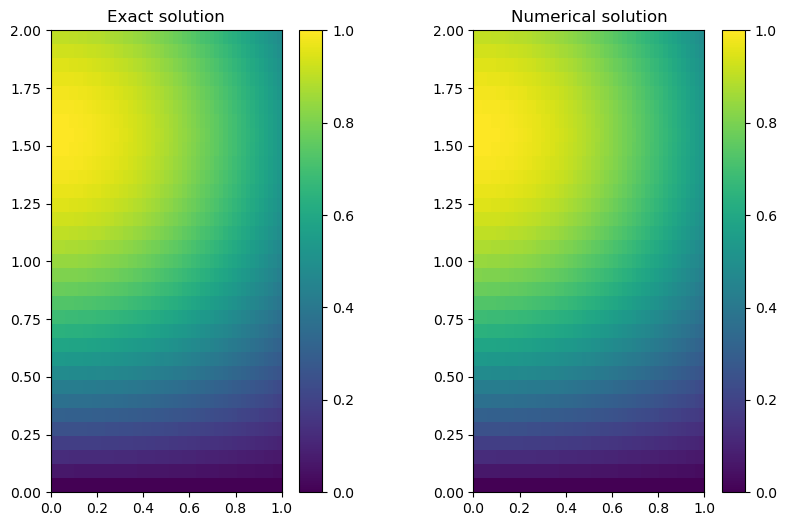

In [73]:
#r = np.pi (irrational)
X,Y,U = poisson(f2,g,exact2, M = 50,r = np.pi)

fig,axs = plt.subplots(1,2,figsize=(10,6))

axs[0].set_title("Exact solution")
#We invert the grids to show the solutions on the normal Cartesian system
im = axs[0].imshow(exact2(X,Y)[::-1],extent = [0,1,0,2])
plt.colorbar(im,ax = axs[0])


axs[1].set_title("Numerical solution")
im = axs[1].imshow(U[::-1],extent = [0,1,0,2])
plt.colorbar(im,ax = axs[1]);

We do a convergence analysis again. This time we expect that the error is not of order 2, since we extend the boundary.

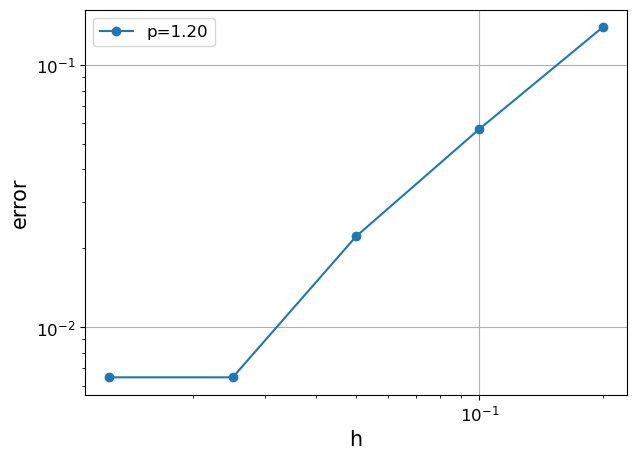

In [74]:
#r = sqrt(2) (irrational)
h,e,o = converge_h(f2,g,exact2,r = np.sqrt(2))

plt.figure(figsize=(7,5))
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12); 

In [75]:
'''
#r = np.pi (irrational)
h,e,o = converge_h(f2,g,exact2,r = np.sqrt(2))

plt.figure(figsize=(14,5))
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend(); 
'''

"\n#r = np.pi (irrational)\nh,e,o = converge_h(f2,g,exact2,r = np.sqrt(2))\n\nplt.figure(figsize=(14,5))\nplt.loglog(h,e,'o-', label='p={:.2f}'.format(o))\nplt.grid('on')\nplt.xlabel('h')\nplt.ylabel('error')\nplt.legend(); \n"

# Part 2


In [76]:
import sympy as sp

In [77]:
def f2(x,y):
    #Redefining this one since the equation changed
    return -2*np.cos(x)*np.sin(y)

In [78]:
def create_grids(M):
    """Helper function. Creates irregular grids with numbering of inner points."""
    h = 1/M
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    grid = np.ones((M+1,M+1))

    ysteps = np.zeros(len(x))
    for i in range(len(x)):
        ysteps[i] = (1-x[i]**2)//h

    X,Y = np.meshgrid(x,y)

    grid = grid * np.where(Y < (1-X**2),1,0)
    grid[:,0] = -1
    grid[0,:] = -1
    
    count = 1
    for i in range(len(grid)):
        for j in range(len(grid)):
            if grid[i,j] == 1:
                grid[i,j] = count
                count += 1
    return X,Y,grid 

In [79]:
def find_neighbours(grid,i):
    """ Helper function to 
        grid: 2d grid with numbered inner points
        i = 1,...,last inner point
        should return the corresponding indexes of neighbours in the 2d grid
    """
    current_coords = np.argwhere(grid == i)[0]
    y,x = current_coords[0],current_coords[1]
    north = np.array([y+1,x])
    east = np.array([y,x+1])
    south = np.array([y-1,x])
    west = np.array([y,x-1])

    return np.array([north,east,south,west])

In [80]:
def BC(X,Y):
    return exact2(X,Y)

In [81]:
def projection(x, y):
    """Calculates the projection of any point in the first quadrant to the curve y = 1-x**2. """
    r = sp.Symbol('r',positive=True)
    solutions = sp.solve(x + r*(1 - 2*y) - 2*r**3)
    real_solution = [n for n in solutions if n.is_real][0]
    return float(round(real_solution,10)), float(1 - round(real_solution,10)**2)

In [82]:
def scheme(f,M = 100,fattening = True):
    h = 1/M
    X,Y,grid = create_grids(M)
    
    number_of_inner_points = int(np.amax(grid))
    index_vector = np.arange(1,number_of_inner_points+1,1) #This is to find the 1D coordinate of the 2D neighbour-coordinates

    A = np.zeros((number_of_inner_points,number_of_inner_points))

    #Evaluate RHS point-by-point
    rhs = np.zeros(number_of_inner_points)
    inner_points_coords = np.argwhere(grid > 0)
    
    for p in range(number_of_inner_points):
        rhs[p] = f(X[inner_points_coords[p][0],inner_points_coords[p][1]],Y[inner_points_coords[p][0],inner_points_coords[p][1]]) 
    rhs = -rhs * h**2
    
    for i in range(number_of_inner_points): #Loop through all inner points, row-by-row construction of A and RHS
        row = np.zeros(number_of_inner_points)
        neighbours = find_neighbours(grid,i+1) #i+1 bcuz 0-indexing. The array values go from 1,...,num_inner_points

        if (fattening):
            row[i] += -4
            for nb in neighbours:
                if (grid[nb[0],nb[1]] == -1): #The neighbour is a boundary point with val -1
                    rhs[i] += BC(X[nb[0],nb[1]],Y[nb[0],nb[1]]) 
                elif (grid[nb[0],nb[1]] == 0): #The neighbour is a boundary point with val 0
                    #Handle B.C. by fattening
                    xp,yp = projection(X[nb[0],nb[1]],Y[nb[0],nb[1]])
                    rhs[i] += BC(xp,yp)
                
                else: #The neighbour is inner point, add to row with correct index
                    row[np.argwhere(index_vector == grid[nb[0],nb[1]])[0][0]] += 1
    
        else: #Modify FDM when we are close to the boundary y = 1-x**2
            fix_boundary = False
            for nb in neighbours:
                if (grid[nb[0],nb[1]] == 0):
                    fix_boundary = True

            if fix_boundary:
                if (grid[neighbours[0,0],neighbours[0,1]] == 0 and grid[neighbours[1,0],neighbours[1,1]] == 0): #North AND East are 0
                    xp = X[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    yp = Y[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    y_Nb = 1-xp**2
                    etta_N = np.abs(yp-y_Nb)/h
                    a_N = 2/(etta_N*(etta_N+1))

                    rhs[i] += a_N*BC(xp,y_Nb) #North contribution
                    row[i] += -2/etta_N #P
                    
                    if (grid[neighbours[2,0],neighbours[2,1]] == -1): #The south neighbour is a boundary point with val -1
                        rhs[i] += (2/(1+etta_N))*BC(X[neighbours[2,0],neighbours[2,1]],Y[neighbours[2,0],neighbours[2,1]])
                    else:
                        row[np.argwhere(index_vector == grid[neighbours[2,0],neighbours[2,1]])[0][0]] += 2/(1+etta_N) #South contribution
                    
                    x_Eb = np.sqrt(1-yp)
                    etta_E = np.abs(xp-x_Eb)/h
                    a_E = 2/(etta_E*(etta_E+1))

                    rhs[i] += a_E*BC(x_Eb,yp) #East contribution
                    row[i] += -2/etta_E #P
                    row[np.argwhere(index_vector == grid[neighbours[3,0],neighbours[3,1]])[0][0]] += 2/(1+etta_E) #West contribution

                elif (grid[neighbours[0,0],neighbours[0,1]] == 0): #Only North
                    xp = X[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    yp = Y[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    y_Nb = 1-xp**2
                    etta_N = np.abs(yp-y_Nb)/h
                    a_N = 2/(etta_N*(etta_N+1))

                    rhs[i] += a_N*BC(xp,y_Nb) #North contribution
                    row[i] += -2/etta_N #P
                    row[np.argwhere(index_vector == grid[neighbours[2,0],neighbours[2,1]])[0][0]] += 2/(1+etta_N) #South contribution

                    row[np.argwhere(index_vector == grid[neighbours[1,0],neighbours[1,1]])[0][0]] += 1 #East contribution
                    row[i] += -2 #P

                    if (grid[neighbours[3,0],neighbours[3,1]] == -1): #The neighbour is a boundary point with val -1
                        rhs[i] += BC(X[neighbours[3,0],neighbours[3,1]],Y[neighbours[3,0],neighbours[3,1]])
                    else:
                        row[np.argwhere(index_vector == grid[neighbours[3,0],neighbours[3,1]])[0][0]] += 1 #West contribution
                    

                elif (grid[neighbours[1,0],neighbours[1,1]] == 0): #Only east
                    xp = X[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    yp = Y[np.argwhere(grid == i+1)[0,0],np.argwhere(grid == i+1)[0,1]]
                    x_Eb = np.sqrt(1-yp)
                    etta_E = np.abs(xp-x_Eb)/h
                    a_E = 2/(etta_E*(etta_E+1))
    
                    rhs[i] += a_E*BC(x_Eb,yp) #East contribution
                    row[i] += -2/etta_E #P
                    row[np.argwhere(index_vector == grid[neighbours[3,0],neighbours[3,1]])[0][0]] += 2/(1+etta_E) #West contribution

                    row[np.argwhere(index_vector == grid[neighbours[0,0],neighbours[0,1]])[0][0]] += 1 #North contribution
                    row[i] += -2 #P
                    row[np.argwhere(index_vector == grid[neighbours[2,0],neighbours[2,1]])[0][0]] += 1 #South contribution
                A[i] = -row
                continue
            row[i] += -4
            for nb in neighbours:
                
                if (grid[nb[0],nb[1]] == -1): #The neighbour is a boundary point with val -1
                    rhs[i] += BC(X[nb[0],nb[1]],Y[nb[0],nb[1]])
                
                else: #The neighbour is inner point, add to row with correct index
                    row[np.argwhere(index_vector == grid[nb[0],nb[1]])[0][0]] += 1
        A[i] = -row
    
    U = BC(X,Y)
    U = U * np.where((Y < (1-X**2+h)+(X < np.sqrt(1-Y)+h)) > 0,1,0)
    Ui = np.linalg.solve(A,rhs)

    #Insert inner point-solutions into entire grid
    for i in range(number_of_inner_points):
        current_coords = np.argwhere(grid == (i+1))[0]
        y,x = current_coords[0],current_coords[1]
        U[y,x] = Ui[i]
    
    return X,Y,U

In [83]:
M = 100
X,Y,U = scheme(f2,M=M,fattening=False)
h = 1/M
exact = exact2(X,Y)
exact = exact * np.where((Y < (1-X**2+h)+(X < np.sqrt(1-Y)+h)) > 0,1,0)

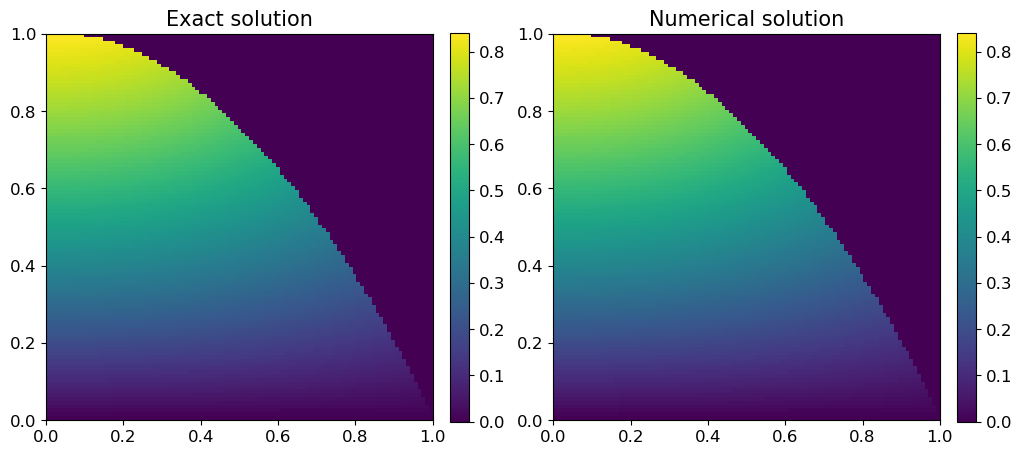

In [84]:
fig,axs = plt.subplots(1,2,figsize=(12,6))

axs[0].set_title("Exact solution", fontsize=15)
#We invert the grids to show the solutions on the normal Cartesian system
im = axs[0].imshow(exact[::-1],extent = [0,1,0,1])
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[0],fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

axs[1].set_title("Numerical solution", fontsize=15)
im = axs[1].imshow(U[::-1],extent = [0,1,0,1])
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
cbar = plt.colorbar(im,ax = axs[1],fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)


In [85]:
#This function is copied from "heat_forweuler.ipynb" and modified to our purposes
def converge2(f,u_exact, solver = scheme,fattening = True):
    K = 5
    Hconv = np.zeros(K)
    Econv = np.zeros(K)
    M = 5
    for k in range(K):
        X,Y,U = solver(f, M=M,fattening=fattening)
        exact = u_exact(X,Y)
        h = 1/M
        Exact = exact * np.where((Y < (1-X**2+h)+(X < np.sqrt(1-Y)+h)) > 0,1,0) - U
        Hconv[k] = (X[0,1]-X[0,0])
        Econv[k] = np.max(np.abs(Exact))
        M = M*2
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

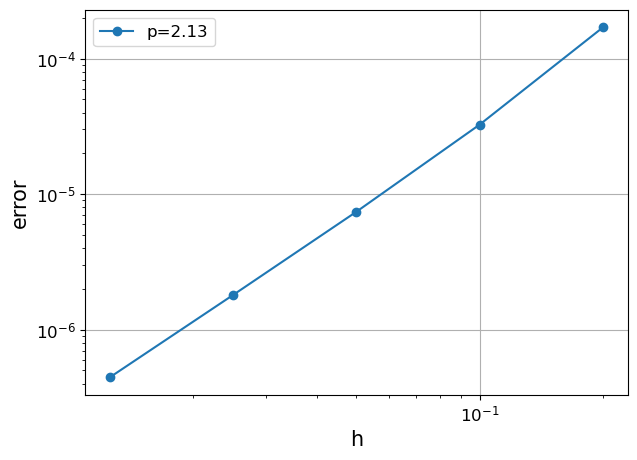

In [86]:
h,e,o = converge2(f2,exact2,fattening = False)

plt.figure(figsize=(7,5))
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12); 

In [87]:
def BC(X,Y):
    #Redefining this one 
    return exact3(X,Y)

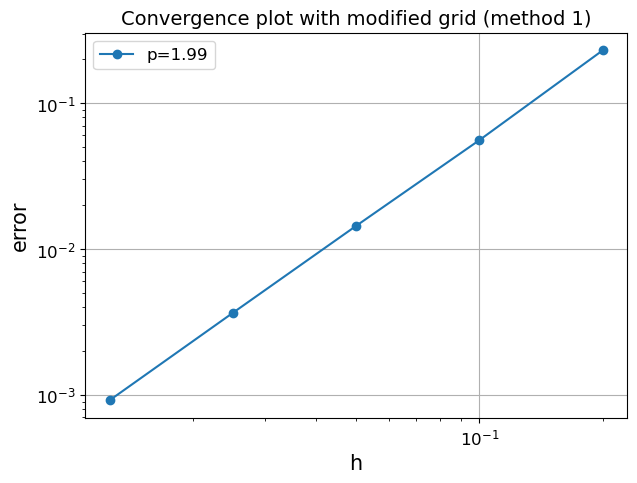

In [88]:
h,e,o = converge2(f3,exact3,fattening = False)

plt.figure(figsize=(7,5))
plt.title("Convergence plot with modified grid (method 1)", fontsize=14)
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12); 

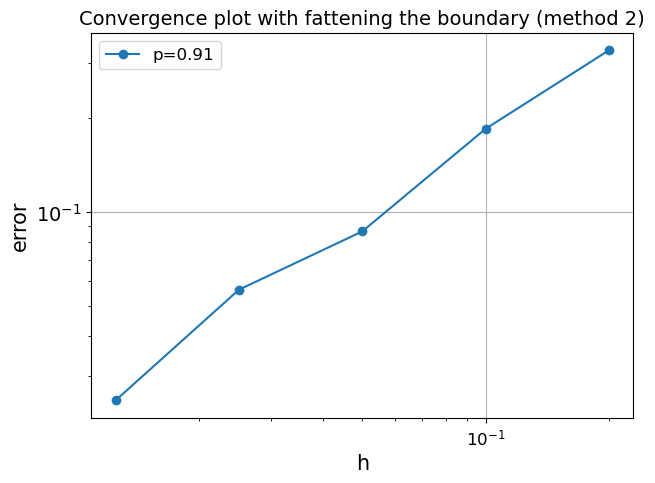

In [89]:
h,e,o = converge2(f3,exact3,fattening = True)

plt.figure(figsize=(7,5))
plt.title("Convergence plot with fattening the boundary (method 2)", fontsize=14)
plt.loglog(h,e,'o-', label='p={:.2f}'.format(o))
plt.grid('on')
plt.xlabel('h', fontsize=15)
plt.ylabel('error', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.legend(fontsize=12); 